In [ ]:
import pandas as pd
import numpy as np

from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mutual_info_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

all_data = pd.read_csv(open('drive/MyDrive/USCensus1990.data.csv', 'r'))
data = all_data.drop(columns = ['caseid', 'dAge', 'dHispanic', 'iYearwrk', 'iSex'])
external_vars_list = ['dAge', 'dHispanic', 'iYearwrk', 'iSex']
external_variables = all_data[external_vars_list]


sample_size = 20000 
data_sample = data.sample(sample_size)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def hist_plot(scores, bins_num, algo_name):
  _, _, _ = plt.hist(scores, bins=bins_num)

  plt.xlabel('Scores')
  plt.ylabel('Frequency')
  if algo_name == 'gmm':
    plt.yscale('log')
  plt.savefig(f'{algo_name}_scores_histogram.pdf')
  plt.show()

In [ ]:
def show_anomalies(scores, anomaly_thre, algo_name):
  order_index = np.argsort(scores, axis = 0)
  indexes_max = order_index[-anomaly_thre:]
  indexes_min = order_index[:anomaly_thre]

  values_min = scores[indexes_min]
  values_max = scores[indexes_max]

  print(values_min)
  print(values_max)

  plt.scatter(indexes_min, values_min, color='m', s=0.9)
  plt.scatter(indexes_max, values_max, color='b', s=0.9)
  # plt.savefig(f'{algo_name}_min_max_scores.pdf')
  plt.show()

In [ ]:
## OneClassSVM
clf = OneClassSVM(gamma='auto')
clf.fit(data_sample)
score_1classSVM = clf.score_samples(data)
score_1classSVM_binary = clf.predict(data)

In [ ]:
## GMM
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
gm.fit(data_sample)
score_gm = gm.score_samples(data)


In [ ]:
## K-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_sample)
score_kmeans = kmeans.transform(data).min(axis=1)

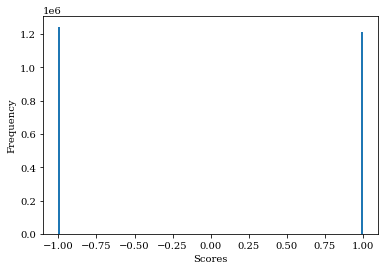

In [ ]:
## arg1: score_1classSVM/score_gm/score_kmeans
## arg3: 'OneClassSVM'/'GMM'/'Kmeans'
hist_plot(score_1classSVM, bins_num=200, algo_name='OneClassSVM')

[4.05034737 4.11664641 4.13464643 4.14079755 4.17344377 4.17344377
 4.18662559 4.18881897 4.20073855 4.20073855 4.20602529 4.209986
 4.21526115 4.2293586  4.23929253 4.24116425 4.24116425 4.2420998
 4.25554889 4.25554889 4.26132641 4.26430529 4.26430529 4.27842664
 4.28213504 4.29219632 4.29361074 4.2956679  4.29712136 4.30228967
 4.30228967 4.31904397 4.31996266 4.31996266 4.32014637 4.32198307
 4.32198307 4.32198307 4.33609962 4.33609962 4.33683169 4.34469367
 4.34469367 4.34469367 4.35655112 4.3603751  4.36801301 4.36801301
 4.36801301 4.3689214  4.37110075 4.3734605  4.37600034 4.3810756
 4.39048552 4.39048552 4.39048552 4.39698828 4.39698828 4.39698828
 4.39698828 4.39698828 4.39698828 4.39825159 4.40582384 4.41194424
 4.41372413 4.41931344 4.42433902 4.42433902 4.42720822 4.42720822
 4.42720822 4.42720822 4.42720822 4.42720822 4.42720822 4.42720822
 4.43005805 4.43061297 4.43294104 4.43294104 4.43294104 4.43562575
 4.43562575 4.43562575 4.43562575 4.43562575 4.43562575 4.43562575

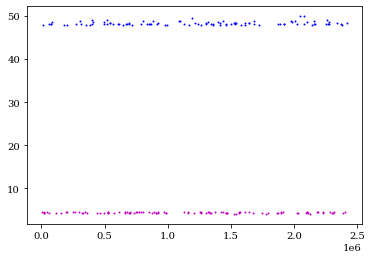

In [ ]:
## arg1: score_1classSVM/score_gm/score_kmeans
## arg3: 'OneClassSVM'/'GMM'/'Kmeans'
show_anomalies(score_kmeans, anomaly_thre=100, algo_name='kmeans')

Algo: oneClassSVM External Variable: dAge Mutual Information: 8.226605160831921e-05
Algo: oneClassSVM External Variable: dHispanic Mutual Information: 7.517736539268663e-06
Algo: oneClassSVM External Variable: iYearwrk Mutual Information: 1.792218503963802e-05
Algo: oneClassSVM External Variable: iSex Mutual Information: 5.28594707431459e-07
Algo: GMM External Variable: dAge Mutual Information: 5.145848084023686e-05
Algo: GMM External Variable: dHispanic Mutual Information: 1.4113889333159426e-06
Algo: GMM External Variable: iYearwrk Mutual Information: 3.063978285348373e-05
Algo: GMM External Variable: iSex Mutual Information: 9.207310516893904e-06
Algo: Kmeans External Variable: dAge Mutual Information: 9.70536170937268e-05
Algo: Kmeans External Variable: dHispanic Mutual Information: 2.130328103800496e-06
Algo: Kmeans External Variable: iYearwrk Mutual Information: 6.812973036636358e-05
Algo: Kmeans External Variable: iSex Mutual Information: 1.576924608404258e-06


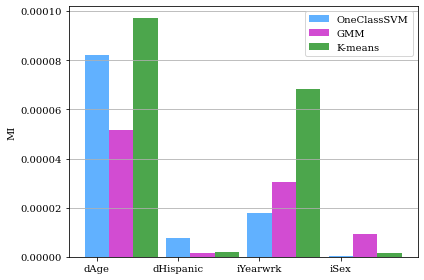

In [ ]:
#### Getting mutual information between anomalies and external variable

algo_names = ['oneClassSVM', 'GMM', 'Kmeans']
scores = [score_1classSVM, score_gm, score_kmeans]
thresholds = [[0.164, 10000000], [-500280.81, 100000000], [0.0, 47.95]]  # ~100 outliears
bias = [0, 0.3, 0.6]
colors = ['dodgerblue', 'm', 'g']

x_pos = np.arange(len(external_vars_list))
fig, ax = plt.subplots()

for algo_name, s, thre, b, c in zip(algo_names, scores, thresholds, bias, colors):
  min_thre = thre[0]
  max_thre = thre[1]
  scores_labels = np.where((s < min_thre) | (s > max_thre), 0, 1)  # anomalies: 0, otherwise: 1

  MI = {}
  for var in external_vars_list:
    mutual_info = mutual_info_score(external_variables[var].to_numpy(), scores_labels)
    MI[var] = mutual_info
    print(f'Algo: {algo_name} External Variable: {var} Mutual Information: {mutual_info}')
  ax.bar(x_pos + b, list(MI.values()), width=0.3, align='center', alpha=0.7, color=c)

ax.set_ylabel('MI')
ax.set_xticks(x_pos)
ax.set_xticklabels(external_vars_list)
ax.yaxis.grid(True)
plt.tight_layout()
plt.legend(['OneClassSVM', 'GMM', 'K-means'])
plt.savefig('MI_anomaly_with_external.pdf')
plt.show()